In [5]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats
from get_draws.api import get_draws

In [6]:
# add list here when complete :) 

output_dirs = ['/share/costeffectiveness/results/vivarium_conic_lsff/ethiopia/2020_06_28_12_40_56/count_data_incomplete/',
               '/share/costeffectiveness/results/vivarium_conic_lsff/india/2020_06_26_20_35_00/count_data/',
              '/share/costeffectiveness/results/vivarium_conic_lsff/nigeria/2020_06_26_20_28_27/count_data/']

locations = ['Ethiopia','India','Nigeria']

In [7]:
anemia_pt = pd.read_hdf(output_dirs[0] + 'anemia_state_person_time.hdf')
anemia_pt.head()

,year,age_group,sex,measure,input_draw,scenario,value
0,2020,1_to_4,female,anemia_mild,29,baseline,6439.033539
1,2020,1_to_4,female,anemia_mild,29,folic_acid_fortification_scale_up,6439.033539
2,2020,1_to_4,female,anemia_mild,29,iron_folic_acid_fortification_scale_up,6439.033539
3,2020,1_to_4,female,anemia_mild,29,vitamin_a_fortification_scale_up,6439.033539
4,2020,1_to_4,female,anemia_mild,223,baseline,6335.953457


In [8]:
# get simulation anemia prevalence

anemia_prev = pd.DataFrame()
for i in range(len(output_dirs)):
    anemia_pt = pd.read_hdf(output_dirs[i] + 'anemia_state_person_time.hdf')
    anemia_pt = anemia_pt.groupby(['input_draw','scenario','year','measure']).sum()
    pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
    pt = pt.loc[pt.cause.str.contains('diarrheal')]
    pt = pt.groupby(['input_draw','scenario','year']).sum()
    prev = anemia_pt / pt
    prev = prev.reset_index()
    prev['location'] = locations[i]
    anemia_prev = anemia_prev.append(prev)
anemia_prev = anemia_prev.rename(columns={'measure':'cause'})

total_anemia_prev = pd.DataFrame()
for i in range(len(output_dirs)):
    anemia_pt = pd.read_hdf(output_dirs[i] + 'anemia_state_person_time.hdf')
    anemia_pt = anemia_pt.loc[anemia_pt.measure != 'anemia_none']
    anemia_pt = anemia_pt.groupby(['input_draw','scenario','year']).sum()
    pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
    pt = pt.loc[pt.cause.str.contains('diarrheal')]
    pt = pt.groupby(['input_draw','scenario','year']).sum()
    prev = anemia_pt / pt
    prev = prev.reset_index()
    prev['location'] = locations[i]
    total_anemia_prev = total_anemia_prev.append(prev)
total_anemia_prev['cause'] = 'total_anemia'

anemia = anemia_prev.append(total_anemia_prev)

baseline_anemia_prev = anemia.loc[anemia.scenario == 'baseline']
baseline_anemia_prev = baseline_anemia_prev.drop(columns='scenario').set_index(['input_draw','year','cause','location'])
anemia_prev_prepped = anemia.set_index(['input_draw','year','cause','location','scenario'])
averted_anemia_prev = baseline_anemia_prev - anemia_prev_prepped
averted_anemia_prev_by_year = averted_anemia_prev.reset_index()
averted_anemia_prev_by_year.head()

/ihme/homes/alibow/.conda/envs/vivarium_conic_lsff/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


,input_draw,year,cause,location,scenario,value
0,21,2020,anemia_mild,India,baseline,0.000000e+00
1,21,2020,anemia_mild,India,folic_acid_fortification_scale_up,5.551115e-17
2,21,2020,anemia_mild,India,iron_folic_acid_fortification_scale_up,0.000000e+00
3,21,2020,anemia_mild,India,vitamin_a_fortification_scale_up,-5.551115e-17
4,21,2020,anemia_mild,Nigeria,baseline,0.000000e+00


In [9]:
# get simulation anemia prevalence

anemia_prev = pd.DataFrame()
for i in range(len(output_dirs)):
    anemia_pt = pd.read_hdf(output_dirs[i] + 'anemia_state_person_time.hdf')
    anemia_pt = anemia_pt.loc[anemia_pt.year != '2020']
    anemia_pt = anemia_pt.groupby(['input_draw','scenario','measure']).sum()
    pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
    pt = pt.loc[pt.cause.str.contains('diarrheal')]
    pt = pt.loc[pt.year != '2020']
    pt = pt.groupby(['input_draw','scenario']).sum()
    prev = anemia_pt / pt
    prev = prev.reset_index()
    prev['location'] = locations[i]
    anemia_prev = anemia_prev.append(prev)
anemia_prev = anemia_prev.rename(columns={'measure':'cause'})

total_anemia_prev = pd.DataFrame()
for i in range(len(output_dirs)):
    anemia_pt = pd.read_hdf(output_dirs[i] + 'anemia_state_person_time.hdf')
    anemia_pt = anemia_pt.loc[anemia_pt.measure != 'anemia_none']
    anemia_pt = anemia_pt.loc[anemia_pt.year != '2020']
    anemia_pt = anemia_pt.groupby(['input_draw','scenario']).sum()
    pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
    pt = pt.loc[pt.cause.str.contains('diarrheal')]
    pt = pt.loc[pt.year != '2020']
    pt = pt.groupby(['input_draw','scenario']).sum()
    prev = anemia_pt / pt
    prev = prev.reset_index()
    prev['location'] = locations[i]
    total_anemia_prev = total_anemia_prev.append(prev)
total_anemia_prev['cause'] = 'total_anemia'

anemia = anemia_prev.append(total_anemia_prev)

baseline_anemia_prev = anemia.loc[anemia.scenario == 'baseline']
baseline_anemia_prev = baseline_anemia_prev.drop(columns='scenario').set_index(['input_draw','cause','location'])
anemia_prev_prepped = anemia.set_index(['input_draw','cause','location','scenario'])
averted_anemia_prev = baseline_anemia_prev - anemia_prev_prepped
averted_anemia_prev_overall = averted_anemia_prev.reset_index()
averted_anemia_prev_overall.head()

,input_draw,cause,location,scenario,value
0,21,anemia_mild,India,baseline,0.000000e+00
1,21,anemia_mild,India,folic_acid_fortification_scale_up,-1.665335e-16
2,21,anemia_mild,India,iron_folic_acid_fortification_scale_up,7.666639e-04
3,21,anemia_mild,India,vitamin_a_fortification_scale_up,-5.556901e-07
4,21,anemia_mild,Nigeria,baseline,0.000000e+00


In [10]:
# state person time for non-anemia causes

prevs = pd.DataFrame()
for i in range(len(output_dirs)):
    state_pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
    state_pt = state_pt.groupby(['input_draw','scenario','year','cause']).sum()
    pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
    pt = pt.loc[pt.cause.str.contains('diarrheal')]
    pt = pt.groupby(['input_draw','scenario','year']).sum()
    prev = state_pt / pt
    prev = prev.reset_index()
    prev['location'] = locations[i]
    prevs = prevs.append(prev)

baseline_prev = prevs.loc[prevs.scenario == 'baseline']
baseline_prev = baseline_prev.drop(columns='scenario').set_index(['input_draw','year','cause','location'])
prev_prepped = prevs.set_index(['input_draw','year','cause','location','scenario'])
averted_prev = baseline_prev - prev_prepped
averted_prev_by_year = averted_prev.reset_index()
averted_prev_by_year.head()

,input_draw,year,cause,location,scenario,value
0,21,2020,diarrheal_diseases,India,baseline,0.000000e+00
1,21,2020,diarrheal_diseases,India,folic_acid_fortification_scale_up,6.938894e-18
2,21,2020,diarrheal_diseases,India,iron_folic_acid_fortification_scale_up,5.204170e-18
3,21,2020,diarrheal_diseases,India,vitamin_a_fortification_scale_up,1.734723e-18
4,21,2020,diarrheal_diseases,Nigeria,baseline,0.000000e+00


In [11]:
# state person time for non-anemia causes

prevs = pd.DataFrame()
for i in range(len(output_dirs)):
    state_pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
    state_pt = state_pt.loc[state_pt.year != '2020']
    state_pt = state_pt.groupby(['input_draw','scenario','cause']).sum()
    pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
    pt = pt.loc[pt.cause.str.contains('diarrheal')]
    pt = pt.loc[pt.year != '2020']
    pt = pt.groupby(['input_draw','scenario']).sum()
    prev = state_pt / pt
    prev = prev.reset_index()
    prev['location'] = locations[i]
    prevs = prevs.append(prev)

baseline_prev = prevs.loc[prevs.scenario == 'baseline']
baseline_prev = baseline_prev.drop(columns='scenario').set_index(['input_draw','cause','location'])
prev_prepped = prevs.set_index(['input_draw','cause','location','scenario'])
averted_prev = baseline_prev - prev_prepped
averted_prev_overall = averted_prev.reset_index()
averted_prev_overall.head()

,input_draw,cause,location,scenario,value
0,21,diarrheal_diseases,India,baseline,0.000000e+00
1,21,diarrheal_diseases,India,folic_acid_fortification_scale_up,-1.214306e-17
2,21,diarrheal_diseases,India,iron_folic_acid_fortification_scale_up,-1.040834e-17
3,21,diarrheal_diseases,India,vitamin_a_fortification_scale_up,4.478656e-04
4,21,diarrheal_diseases,Nigeria,baseline,0.000000e+00


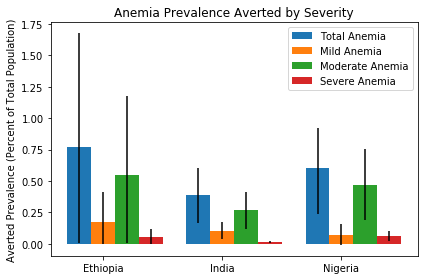

In [12]:
dataset = averted_anemia_prev_overall
scenario = 'iron_folic_acid_fortification_scale_up'

barWidth = 0.2

data = dataset.loc[dataset.scenario == scenario]
data['value'] = data['value'] * 100
data = data.groupby(['location','scenario','cause']).describe(percentiles=[0.1,0.9]).reset_index()

data1 = data.loc[data.cause == 'total_anemia']
data2 = data.loc[data.cause == 'anemia_mild']
data3 = data.loc[data.cause == 'anemia_moderate']
data4 = data.loc[data.cause == 'anemia_severe']

a = np.arange(len(data1))
b = [x + barWidth for x in a]
c = [x + barWidth for x in b]
d = [x + barWidth for x in c]

plt.bar(a, data1['value','mean'], width=barWidth, yerr=[(data1['value','mean'] - data1['value','10%']),
                                       (data1['value','90%'] - data1['value','mean'])])
plt.bar(b, data2['value','mean'],  width=barWidth, yerr=[(data2['value','mean'] - data2['value','10%']),
                                       (data2['value','90%'] - data2['value','mean'])])
plt.bar(c, data3['value','mean'], width=barWidth, yerr=[(data3['value','mean'] - data3['value','10%']),
                                       (data3['value','90%'] - data3['value','mean'])])
plt.bar(d, data4['value','mean'], width=barWidth, yerr=[(data4['value','mean'] - data4['value','10%']),
                                       (data4['value','90%'] - data4['value','mean'])])

plt.xticks([r + barWidth for r in range(len(data1))], np.unique(data1['location']))
plt.ylabel('Averted Prevalence (Percent of Total Population)')
plt.title('Anemia Prevalence Averted by Severity')
plt.legend(['Total Anemia','Mild Anemia','Moderate Anemia','Severe Anemia'])
plt.tight_layout()
plt.savefig(f'anemia_prevalence_averted_by_severity.png')

In [13]:
def make_averted_prevalence_bar_chart_for_single_scenario(dataset, scenario, cause):
    
    data = dataset.loc[dataset.scenario == scenario]
    data = data.loc[data.cause == cause]
    data['value'] = data['value'] * 100
    data = data.groupby(['location','scenario']).describe(percentiles=[0.1,0.9]).reset_index()
    a = np.arange(len(data))
    
    
    plt.bar(a, data['value','mean'], yerr=[(data['value','mean'] - data['value','10%']),
                                           (data['value','90%'] - data['value','mean'])])
    
    
    scenario_title = scenario.replace('_',' ').capitalize()
    if cause == 'anemia_mild':
        cause_title = 'Mild Anemia'
    elif cause == 'anemia_moderate':
        cause_title = 'Moderate Anemia'
    elif cause == 'anemia_severe':
        cause_title = 'Severe Anemia'
    elif cause == 'total_anemia':
        cause_title = 'Anemia'
    else:
        cause_title = cause.replace('_',' ').capitalize()

    plt.xticks([r for r in range(len(data))], np.unique(data['location']))
    plt.ylabel('Averted Prevalence (Percent of Total Population)')
    plt.title(f'{scenario_title}\n {cause_title} Prevalence Averted')
    plt.tight_layout()
    plt.savefig(f'prevalence_averted_overall_{cause}.png')

In [14]:
def make_averted_prevalence_bar_chart_for_single_scenario(dataset, scenario, cause):
    
    data = dataset.loc[dataset.scenario == scenario]
    data = data.loc[data.cause == cause]
    data['value'] = data['value'] * 100
    data = data.groupby(['location','scenario']).describe(percentiles=[0.1,0.9]).reset_index()
    a = np.arange(len(data))
    
    
    plt.bar(a, data['value','mean'], yerr=[(data['value','mean'] - data['value','10%']),
                                           (data['value','90%'] - data['value','mean'])])
    
    
    scenario_title = scenario.replace('_',' ').capitalize()
    if cause == 'anemia_mild':
        cause_title = 'Mild Anemia'
    elif cause == 'anemia_moderate':
        cause_title = 'Moderate Anemia'
    elif cause == 'anemia_severe':
        cause_title = 'Severe Anemia'
    elif cause == 'total_anemia':
        cause_title = 'Anemia'
    else:
        cause_title = cause.replace('_',' ').capitalize()

    plt.xticks([r for r in range(len(data))], np.unique(data['location']))
    plt.ylabel('Averted Prevalence (Percent of Total Population)')
    plt.title(f'{scenario_title}\n {cause_title} Prevalence Averted')
    plt.tight_layout()
    plt.savefig(f'prevalence_averted_overall_{cause}.png')

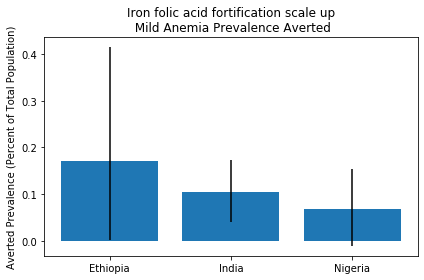

In [15]:
make_averted_prevalence_bar_chart_for_single_scenario(averted_anemia_prev_overall, 
                                                      'iron_folic_acid_fortification_scale_up', 
                                                      'anemia_mild')

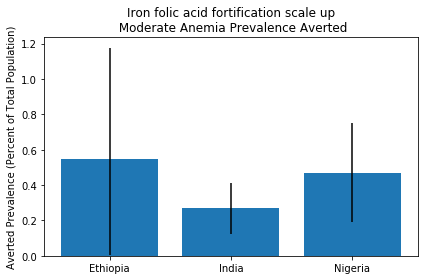

In [16]:
make_averted_prevalence_bar_chart_for_single_scenario(averted_anemia_prev_overall, 
                                                      'iron_folic_acid_fortification_scale_up', 
                                                      'anemia_moderate')

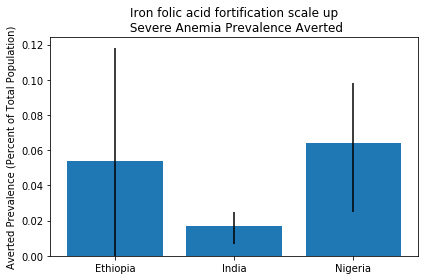

In [17]:
make_averted_prevalence_bar_chart_for_single_scenario(averted_anemia_prev_overall, 
                                                      'iron_folic_acid_fortification_scale_up', 
                                                      'anemia_severe')

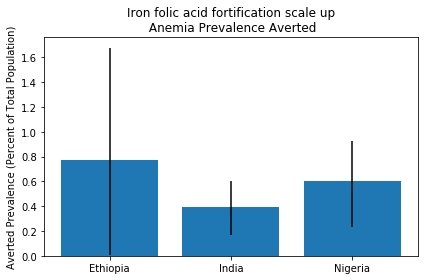

In [18]:
make_averted_prevalence_bar_chart_for_single_scenario(averted_anemia_prev_overall, 
                                                      'iron_folic_acid_fortification_scale_up', 
                                                      'total_anemia')

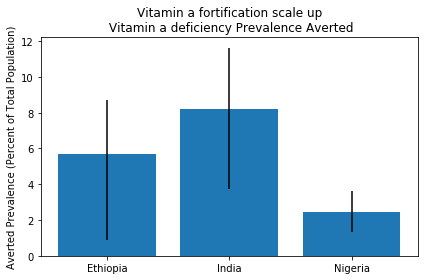

In [19]:
make_averted_prevalence_bar_chart_for_single_scenario(averted_prev_overall, 'vitamin_a_fortification_scale_up', 'vitamin_a_deficiency')

In [20]:
averted_anemia_prev_by_year.head()

,input_draw,year,cause,location,scenario,value
0,21,2020,anemia_mild,India,baseline,0.000000e+00
1,21,2020,anemia_mild,India,folic_acid_fortification_scale_up,5.551115e-17
2,21,2020,anemia_mild,India,iron_folic_acid_fortification_scale_up,0.000000e+00
3,21,2020,anemia_mild,India,vitamin_a_fortification_scale_up,-5.551115e-17
4,21,2020,anemia_mild,Nigeria,baseline,0.000000e+00


In [21]:
scenario = 'iron_folic_acid_fortification_scale_up'
cause = 'total_anemia'
dataset = averted_anemia_prev_by_year

data = dataset.loc[dataset.scenario == scenario]
data = dataset.loc[dataset.cause == cause]
#data = data.groupby(['location','year']).describe(percentiles=[0.1,0.9]).reset_index()
#data['value'] = data['value'] * 100
data.head()

,input_draw,year,cause,location,scenario,value
32,21,2020,total_anemia,India,baseline,0.000000e+00
33,21,2020,total_anemia,India,folic_acid_fortification_scale_up,1.110223e-16
34,21,2020,total_anemia,India,iron_folic_acid_fortification_scale_up,0.000000e+00
35,21,2020,total_anemia,India,vitamin_a_fortification_scale_up,0.000000e+00
36,21,2020,total_anemia,Nigeria,baseline,0.000000e+00


In [22]:
def make_multiple_plots_by_year_and_cause(dataset, scenarios, causes):
    for cause in causes:
        for scenario in scenarios:
            data = dataset.loc[dataset.scenario == scenario]
            data = data.loc[dataset.cause == cause]
            data = data.groupby(['location','year']).describe(percentiles=[0.1,0.9]).reset_index()
            data['value'] = data['value'] * 100

            ethiopia = data.loc[data.location == 'Ethiopia']
            india = data.loc[data.location == 'India']
            nigeria = data.loc[data.location == 'Nigeria']

            fig, ax = plt.subplots(figsize=(7.5, 5))

            plt.scatter(ethiopia['year'], ethiopia['value','mean'])
            plt.plot(ethiopia['year'], ethiopia['value','mean'])

            plt.scatter(india['year'], india['value','mean'])
            plt.plot(india['year'], india['value','mean'])

            plt.scatter(nigeria['year'], nigeria['value','mean'])
            plt.plot(nigeria['year'], nigeria['value','mean'])

            plt.fill_between(ethiopia['year'],ethiopia['value','90%'],ethiopia['value','10%'], alpha=0.3,color='tab:blue')
            plt.fill_between(india['year'],india['value','90%'],india['value','10%'], alpha=0.3,color='tab:orange')
            plt.fill_between(nigeria['year'],nigeria['value','90%'],nigeria['value','10%'], alpha=0.3,color='tab:green')

            if cause == 'anemia_mild':
                cause_title = 'Mild Anemia'
            elif cause == 'anemia_moderate':
                cause_title = 'Moderate Anemia'
            elif cause == 'anemia_severe':
                cause_title = 'Severe Anemia'
            elif cause == 'total_anemia':
                cause_title = 'Anemia'
            else:
                cause_title = cause.replace('_',' ').capitalize()
                
            scenario_title = scenario.replace('_',' ').capitalize()

            plt.title(f'{scenario_title} \n Averted {cause_title} Prevalence')
            plt.legend(['Ethiopia','India','Nigeria'])
            plt.ylabel('Averted Prevalence (Percent of Total Population)')
            plt.tight_layout()
            plt.savefig(f'prevalence_averted_by_year_{cause}.png')

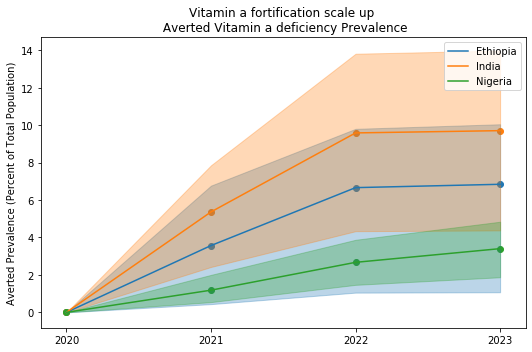

In [23]:
dataset = averted_prev_by_year
causes = ['vitamin_a_deficiency']
scenarios = ['vitamin_a_fortification_scale_up']

make_multiple_plots_by_year_and_cause(dataset, scenarios, causes)

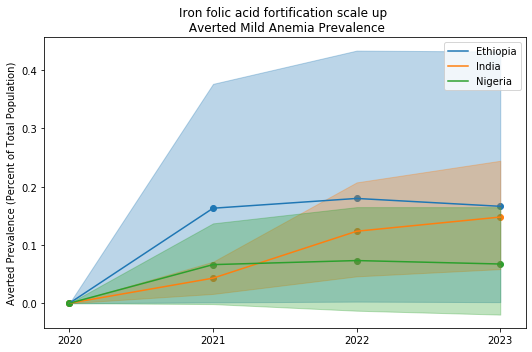

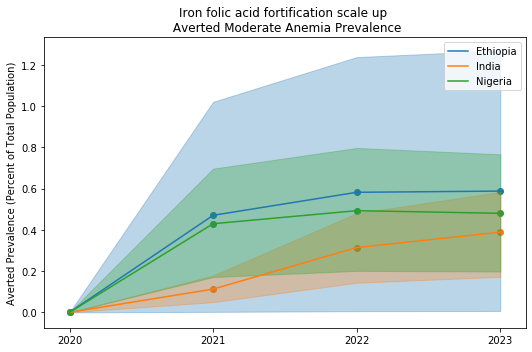

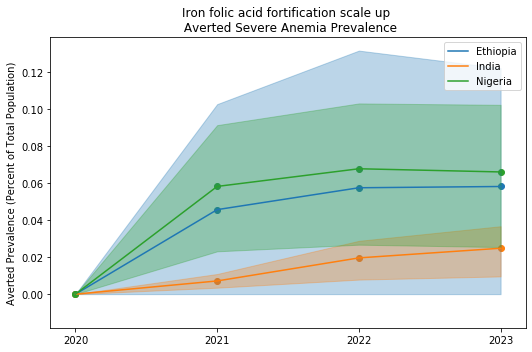

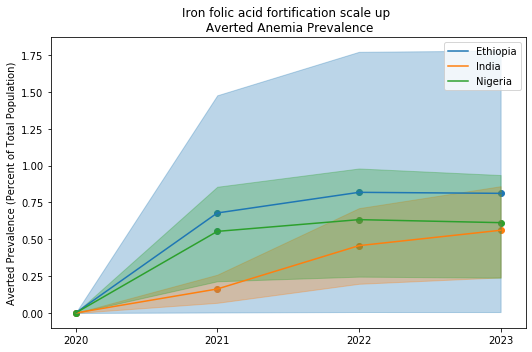

In [24]:
dataset = averted_anemia_prev_by_year
causes = ['anemia_mild','anemia_moderate','anemia_severe','total_anemia']
scenarios = ['iron_folic_acid_fortification_scale_up']

make_multiple_plots_by_year_and_cause(dataset, scenarios, causes)